<a href="https://colab.research.google.com/github/JJ-Zhang-DS/CNN_circle_identification/blob/main/circle_finder_cnn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circle Finder CNN

This notebook demonstrates the implementation of Convolutional Neural Networks (CNNs) for detecting circles in noisy images.

**Key Components**

* Data Generation: Functions to generate synthetic circle images with controllable noise levels
* Evaluation Metrics: Implementation of Intersection over Union (IoU) for accurate assessment
* Visualization Tools: Functions to display model predictions against ground truth
* Custom Loss Functions: Specialized IoU and combined loss functions optimized for circle detection

**Model Implementations**

1. Standard CNN (Final Submission)

* Three convolutional blocks with batch normalization and dropout for regularization
* Fully connected layers with additional regularization techniques
* Sigmoid activation for normalized coordinate and radius output
* Comprehensive training loop with learning rate scheduling and early stopping

2. Experimental Circle Kernel CNN

* Augments a standard CNN with specialized circle detection kernels
* Initializes convolutional filters with circle patterns of different radii
* Combines standard convolutional path with circle-specialized path
* Implementation remains incomplete, included as an exploratory attempt within time constraints

The notebook includes training results, loss curves, and visualization of predictions for both approaches, with the standard CNN serving as the final submission.


## Setup and Environment


In [1]:
## 1. Install Required Packages
!pip install shapely scikit-image shapely

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# create a new folder data to store data
#!mkdir /content/drive/MyDrive/data

Mounted at /content/drive


## Imports and Dependencies


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter_aa
from glob import glob
from shapely.geometry import Point

## Data Generation Functions


In [7]:
def draw_circle(radius, x, y):
    """
    Function to generate an anti-aliased circle and draw it into
    a sect of pixels
    """
    rr, cc, value = circle_perimeter_aa(x, y, radius)
    is_valid = np.logical_and(np.logical_and(rr >= 0, rr < 256), np.logical_and(cc >= 0, cc < 256))
    img = np.zeros((256, 256))
    img[rr[is_valid], cc[is_valid]] = 2*value[is_valid]
    return img

def generate_circle(noise_level=2, rad_min=3, rad_max=20):
    """
    Function to generate an image with a circle obscured by some noise.
    Core function for generating the images you need to run your model against.
    DO NOT CHANGE.

    For training a model X = img, Y = labels (you will need more than one component in
    your prediction output (row, col, radius))
    """
    row = np.random.randint(0, 256)
    col = np.random.randint(0, 256)
    radius = np.random.randint(rad_min, rad_max)
    img = draw_circle(radius, row, col)
    img += noise_level * np.random.rand(256, 256)
    label = {'row': row, 'col': col, 'radius': radius, 'noise_level': noise_level}
    return img, label

def generate_circle_dataset(path, avg_noise=2, n=10):
    """
    Helper function to show how you can pre-save a bunch of circle images with
    their associated label information for the purposes of your data.
    """
    for idx in range(n):
        img, label = generate_circle(np.max([0, np.random.normal(avg_noise, avg_noise/2.0)]))
        with open(f'{path}/file{idx}.json', 'w') as f:
            json.dump({'img': img.tolist(), 'label': label}, f)

def load_dataset_and_plot(path, n_to_show=10):
    """
    Provided as a demo for how to load a dataset you've generated and get the img
    and configuration data from your dataset. This is not necessary to use for the
    takehome assignment and is simply here to give you some help getting started
    if needed.
    """
    idx=0
    for file in glob(f'{path}/*.json'):
        with open(file,'r') as f:
            example_data = json.load(f)
            print(file)
            print(example_data['label'])
            img = np.array(example_data['img'])
            plt.imshow(img)
            plt.show()
            idx+=1
        if idx >= n_to_show:
            break

## Dataset Generation and Visualization


In [8]:
# produce dataset
data_path = 'drive/MyDrive/data'
#data_path = 'data/'
#generate_circle_dataset(data_path, n=10)

data/file9.json
{'row': 7, 'col': 117, 'radius': 19, 'noise_level': 2.492773822957507}


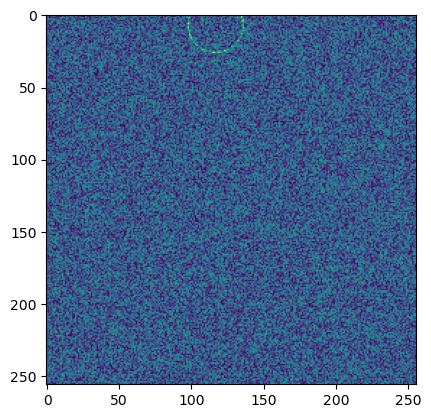

data/file83.json
{'row': 63, 'col': 10, 'radius': 14, 'noise_level': 2.679185815382048}


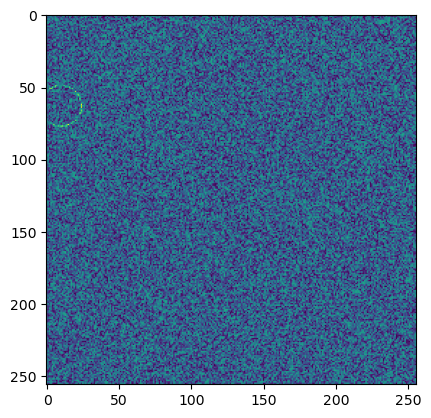

data/file95.json
{'row': 221, 'col': 70, 'radius': 7, 'noise_level': 1.6980196162651444}


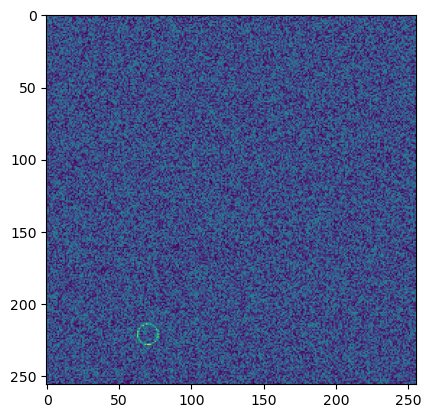

data/file56.json
{'row': 122, 'col': 233, 'radius': 4, 'noise_level': 4.2153304562395215}


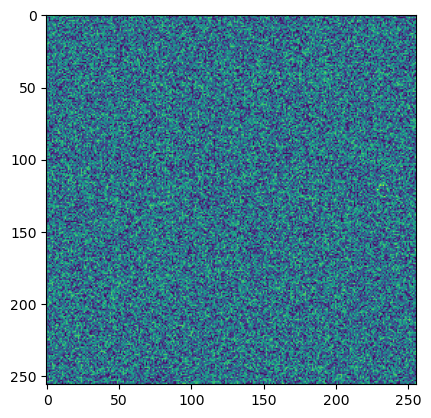

In [ ]:
# show what the dataset looks like
load_dataset_and_plot(data_path, 4)


## Model Evaluation Functions



In [9]:
def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area

def evaluate_model(model, dataloader, device, iou_threshold=0.7):
    model.eval()
    matches = 0
    total = 0
    all_ious = []  # Track all IoU values

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs).cpu().numpy()
            targets = targets.numpy()
            for pred, true in zip(outputs, targets):
                # Denormalize for IoU calculation
                pred_row = pred[0] * IMG_SIZE
                pred_col = pred[1] * IMG_SIZE
                pred_radius = pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN

                true_row = true[0] * IMG_SIZE
                true_col = true[1] * IMG_SIZE
                true_radius = true[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN

                pred_dict = {'row': pred_row, 'col': pred_col, 'radius': pred_radius}
                true_dict = {'row': true_row, 'col': true_col, 'radius': true_radius}

                iou = intersection_over_union(pred_dict, true_dict)
                all_ious.append(iou)

                if iou > iou_threshold:
                    matches += 1
                total += 1

    # Calculate more informative metrics
    accuracy = matches / total
    mean_iou = sum(all_ious) / len(all_ious)
    median_iou = sorted(all_ious)[len(all_ious)//2]

    # Show distribution in IoU brackets
    brackets = [0.5, 0.6, 0.7, 0.8, 0.9]
    bracket_counts = [sum(1 for iou in all_ious if iou > thresh) / total for thresh in brackets]

    print(f"IoU > {iou_threshold} Accuracy: {accuracy:.2%}")
    print(f"Mean IoU: {mean_iou:.4f}, Median IoU: {median_iou:.4f}")
    print("IoU Distribution:")
    for thresh, count in zip(brackets, bracket_counts):
        print(f"  IoU > {thresh:.1f}: {count:.2%}")

    return accuracy, mean_iou, all_ious

## Custom Loss Functions


In [10]:
def iou_loss(pred, target, epsilon=1e-6, target_threshold=0.7):
    """Enhanced IoU loss with threshold focus."""
    # Denormalize predictions and targets
    pred_row = pred[:, 0] * IMG_SIZE
    pred_col = pred[:, 1] * IMG_SIZE
    pred_radius = pred[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN

    target_row = target[:, 0] * IMG_SIZE
    target_col = target[:, 1] * IMG_SIZE
    target_radius = target[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN

    # Distance between centers
    center_dist = torch.sqrt((pred_row - target_row)**2 + (pred_col - target_col)**2)

    # Sum of radii
    radii_sum = pred_radius + target_radius

    # Base IoU component calculation
    dist_loss = center_dist / (radii_sum + epsilon)
    radius_loss = torch.abs(pred_radius - target_radius) / (radii_sum + epsilon)
    base_iou_loss = dist_loss + radius_loss

    # Estimated IoU - approximate conversion from our distance metrics
    # This is a rough approximation to help with scaling
    est_iou = 1.0 - torch.clamp(base_iou_loss, 0.0, 1.0)

    # Apply increased penalty for predictions near but below threshold
    # This creates a "soft hinge" that pushes predictions to exceed the threshold
    threshold_penalty = torch.where(
        (est_iou < target_threshold) & (est_iou > target_threshold - 0.2),
        1.5 * (target_threshold - est_iou),  # 1.5x penalty in the critical region
        torch.zeros_like(est_iou)
    )

    # Combined loss with threshold incentive
    return base_iou_loss.mean() + threshold_penalty.mean()

def combined_loss(pred, target, alpha=0.6):
    """Combined MSE and enhanced IoU loss."""
    mse_component = F.mse_loss(pred, target)
    iou_component = iou_loss(pred, target, target_threshold=0.7)

    # Slightly higher alpha - focus more on IoU now that training is stable
    return alpha * iou_component + (1-alpha) * mse_component

## Visualization Functions


In [11]:
# Show some predictions
# --------- Evaluation and Visualization ---------
def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        # Denormalize
        true_row = true[0].item() * IMG_SIZE
        true_col = true[1].item() * IMG_SIZE
        true_rad = true[2].item() * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        pred_row = pred[0] * IMG_SIZE
        pred_col = pred[1] * IMG_SIZE
        pred_rad = pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle((true_col, true_row), true_rad, color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle((pred_col, pred_row), pred_rad, color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        axs[i].set_title(f"IoU: {intersection_over_union({'row': true_row, 'col': true_col, 'radius': true_rad}, {'row': pred_row, 'col': pred_col, 'radius': pred_rad}):.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


## Dataset Implementation


In [12]:
# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    """
    Dataset that generates circle images on-the-fly instead of loading from disk
    """
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

In [13]:
# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

## CNN model

with dropout + Batch Norm + adam, final selected


Epoch 1, Train Loss: 2.9974, Val Loss: 2.8367, LR: 1.00e-04
Epoch 10, Train Loss: 0.6839, Val Loss: 0.4314, LR: 1.00e-04
Epoch 20, Train Loss: 0.5437, Val Loss: 0.3468, LR: 1.00e-04
Epoch 30, Train Loss: 0.4854, Val Loss: 0.3102, LR: 1.00e-04
Epoch 40, Train Loss: 0.4407, Val Loss: 0.2932, LR: 1.00e-04
Epoch 50, Train Loss: 0.4175, Val Loss: 0.2740, LR: 1.00e-04
Epoch 60, Train Loss: 0.3994, Val Loss: 0.2490, LR: 1.00e-04
Epoch 70, Train Loss: 0.3916, Val Loss: 0.2371, LR: 1.00e-04
Epoch 80, Train Loss: 0.3803, Val Loss: 0.2363, LR: 1.00e-04
Epoch 90, Train Loss: 0.3732, Val Loss: 0.2342, LR: 1.00e-04
Epoch 100, Train Loss: 0.3610, Val Loss: 0.2218, LR: 1.00e-04
Epoch 110, Train Loss: 0.3655, Val Loss: 0.2164, LR: 1.00e-04
Epoch 120, Train Loss: 0.3490, Val Loss: 0.2184, LR: 1.00e-04
Epoch 130, Train Loss: 0.3519, Val Loss: 0.1946, LR: 1.00e-04
Epoch 140, Train Loss: 0.3415, Val Loss: 0.1903, LR: 1.00e-04
Epoch 150, Train Loss: 0.3376, Val Loss: 0.1732, LR: 1.00e-04
Epoch 160, Train Lo

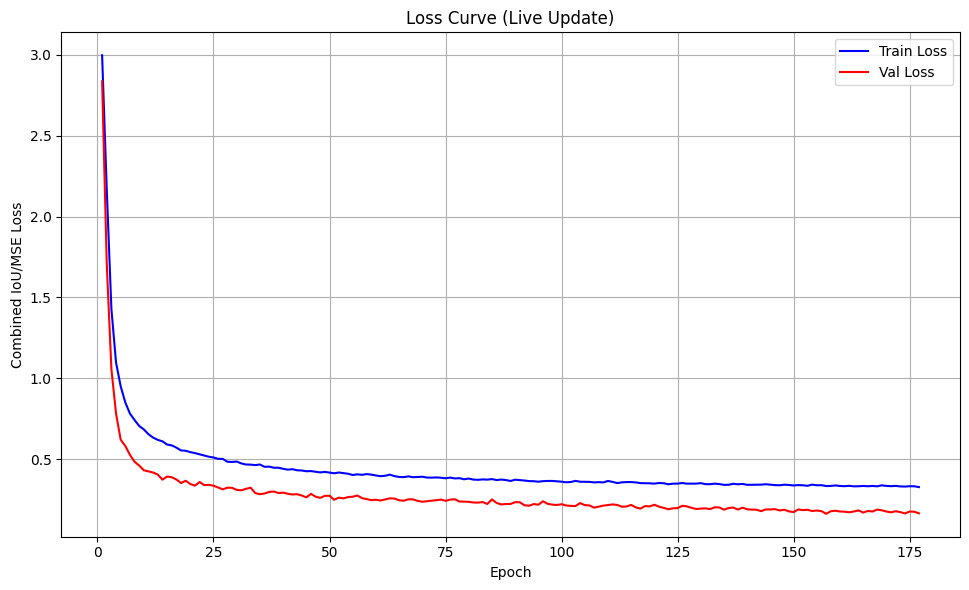

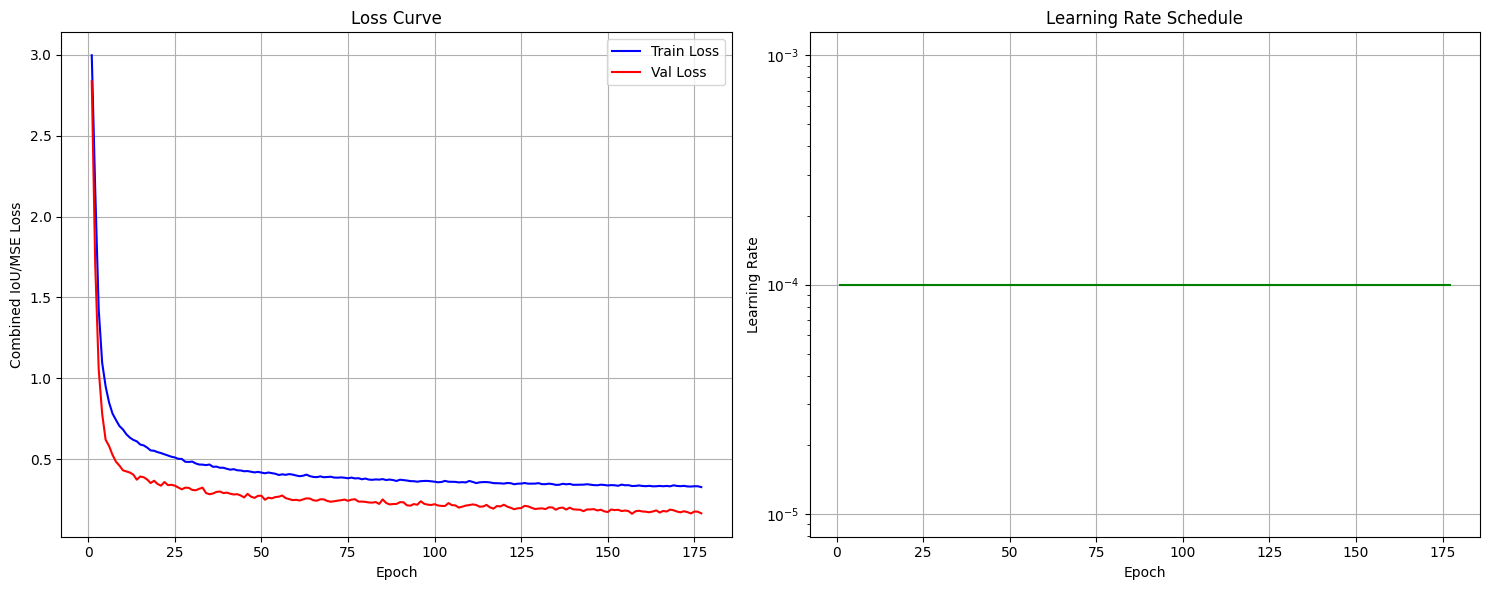

IoU > 0.7 Accuracy: 53.85%
Mean IoU: 0.6388, Median IoU: 0.7253
IoU Distribution:
  IoU > 0.5: 75.25%
  IoU > 0.6: 67.30%
  IoU > 0.7: 53.85%
  IoU > 0.8: 31.70%
  IoU > 0.9: 6.35%


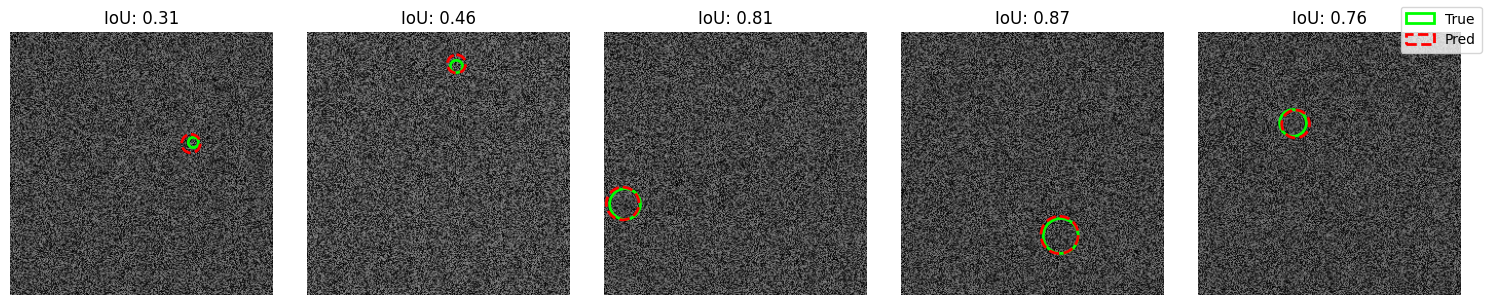

Model saved


In [26]:
class CircleFinderCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CircleFinderCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm after conv2

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm after conv3

        # Dropout layers
        self.dropout_conv = nn.Dropout2d(dropout_rate/2)
        self.dropout_fc = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 32 * 32, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # BatchNorm after fc1

        self.fc2 = nn.Linear(1024, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)  # BatchNorm after fc2

        self.fc3 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First conv block with BN
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        # Second conv block with BN
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        # Third conv block with BN
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout_conv(x)

        # Flatten for fully connected layers
        x = x.view(-1, 64 * 32 * 32)

        # First FC block with BN
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)

        # Second FC block with BN
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout_fc(x)

        # Output layer
        x = self.sigmoid(self.fc3(x))
        return x

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=200, lr=1e-4, patience=20):
    # Create optimizer with initial learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler - reduce LR when progress plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',           # Minimize validation loss
        factor=0.2,           # Multiply LR by 0.2 when triggered
        patience=20,          # Wait 10 epochs of no improvement
        verbose=True,         # Print message when LR changes
        min_lr=1e-6           # Don't go below this LR
    )

    def loss_function(pred, target):
        return combined_loss(pred, target, alpha=0.6)

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    # Set up the live plot
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Combined IoU/MSE Loss')
    ax.set_title('Loss Curve (Live Update)')
    ax.grid(True)
    train_line, = ax.plot([], [], 'b-', label='Train Loss')
    val_line, = ax.plot([], [], 'r-', label='Val Loss')
    ax.legend()
    plt.tight_layout()

    # Lists to store epoch numbers and learning rates
    epochs_list = []
    lr_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        epochs_list.append(epoch + 1)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)  # For ReduceLROnPlateau
        # scheduler.step()        # For MultiStepLR

        # Store current learning rate
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Only print loss every 10 epochs (or for the first epoch)
        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Update the live plot
        train_line.set_data(epochs_list, train_losses)
        val_line.set_data(epochs_list, val_losses)
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Autoscale
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Turn off interactive mode after training
    plt.ioff()

    # Final static plot - now with two subplots
    plt.figure(figsize=(15, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs_list, val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Combined IoU/MSE Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Learning rate plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, lr_history, 'g-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.show()


# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=20000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    # A100-optimized DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=True,
        num_workers=4,
        pin_memory=True,  # Important for faster CPU->GPU data transfer
    #    persistent_workers=True  # Keeps workers alive between iterations
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=256,
        shuffle=False,  # No need to shuffle validation data
        num_workers=4,
        pin_memory=True
    )


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=200)
    evaluate_model(model, val_loader, device)
    show_predictions(model, val_dataset, device, num_samples=5)
    # Save the trained model
    import os
    model.to('cpu')  # Move to CPU for saving
    torch.save(model, 'circle_finder_model.pkl')
    print("Model saved")

## **CNN + circle kernel**

Epoch 1, Train Loss: 2.2501, Val Loss: 2.2281, LR: 1.00e-04
Epoch 10, Train Loss: 1.1948, Val Loss: 1.1693, LR: 1.00e-04
Epoch 20, Train Loss: 0.7773, Val Loss: 0.7574, LR: 1.00e-04
Epoch 30, Train Loss: 0.4721, Val Loss: 0.5021, LR: 1.00e-04
Epoch 40, Train Loss: 0.3642, Val Loss: 0.3260, LR: 1.00e-04
Epoch 50, Train Loss: 0.2702, Val Loss: 0.2628, LR: 1.00e-04
Epoch 60, Train Loss: 0.2209, Val Loss: 0.2456, LR: 1.00e-04
Epoch 70, Train Loss: 0.2047, Val Loss: 0.1952, LR: 1.00e-04
Epoch 80, Train Loss: 0.1876, Val Loss: 0.1951, LR: 1.00e-04
Epoch 90, Train Loss: 0.1794, Val Loss: 0.1894, LR: 1.00e-04
Epoch 100, Train Loss: 0.1637, Val Loss: 0.1669, LR: 1.00e-04


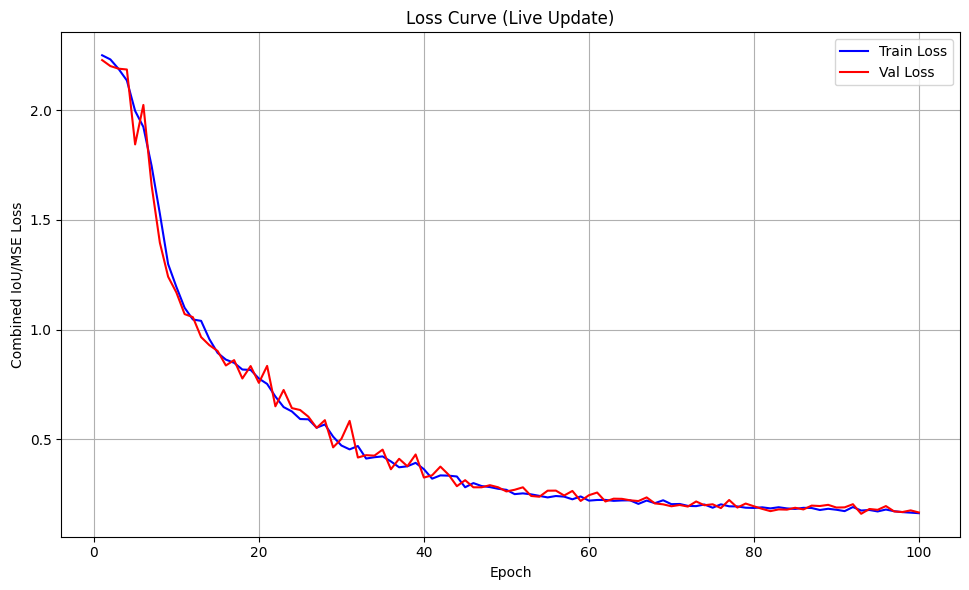

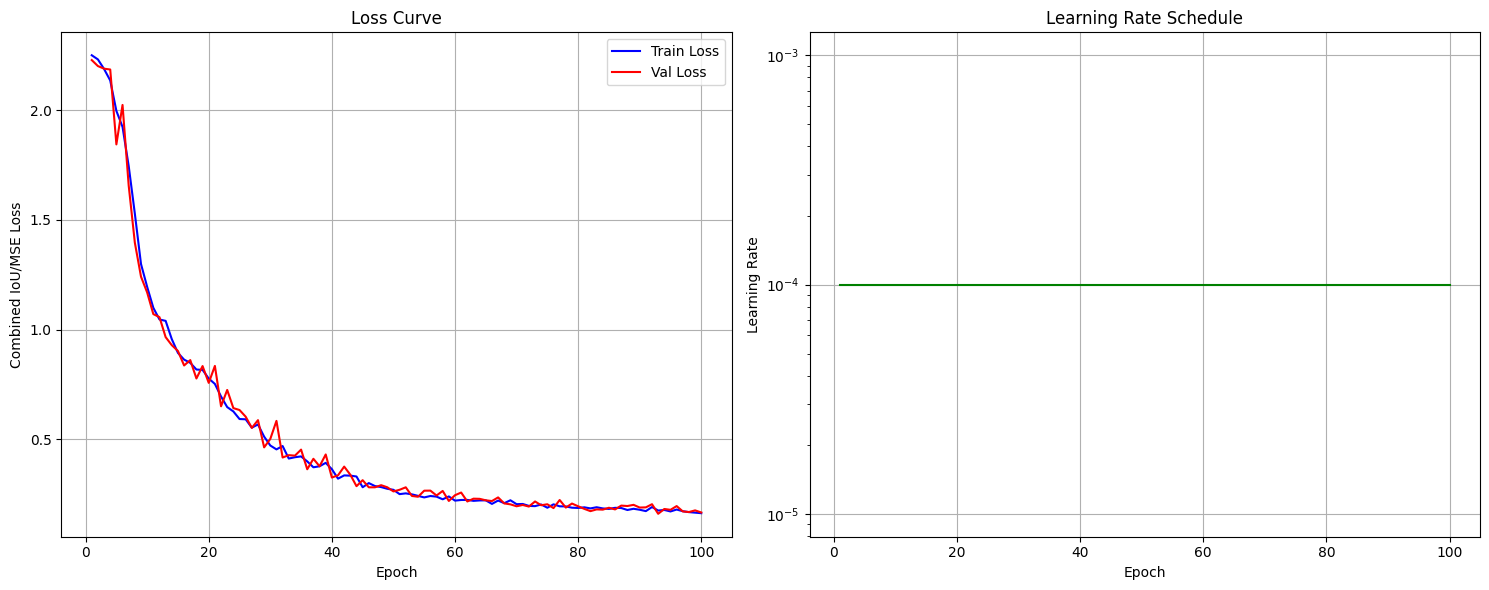

IoU > 0.7 Accuracy: 43.20%
Mean IoU: 0.6285, Median IoU: 0.6695
IoU Distribution:
  IoU > 0.5: 76.85%
  IoU > 0.6: 64.30%
  IoU > 0.7: 43.20%
  IoU > 0.8: 20.00%
  IoU > 0.9: 2.70%


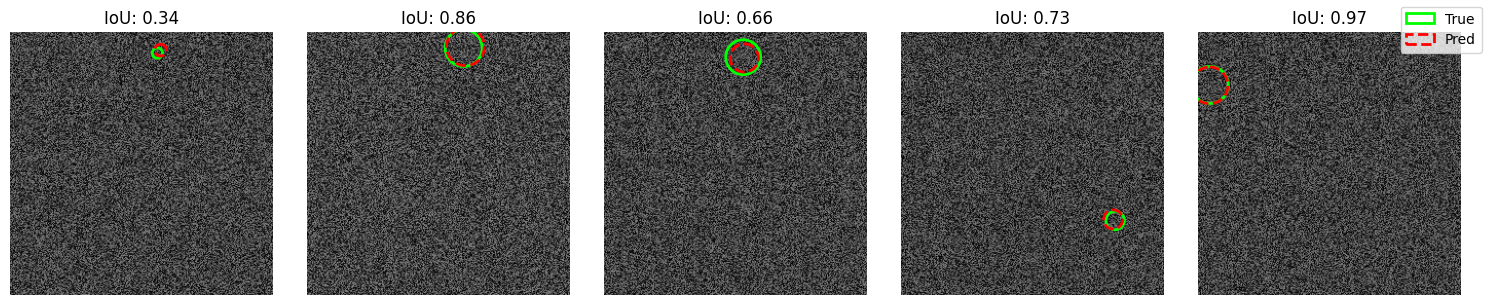

TypeError: CircleFinderCNN.__init__() got an unexpected keyword argument 'dropout_rate'

In [ ]:
# Add circle kernel creation function
def create_circle_kernel(radius, size=None):
    """Create a kernel that responds to circles of a specific radius"""
    if size is None:
        size = 2 * radius + 3  # Instead of +5

    kernel = np.zeros((size, size))
    center = size // 2

    y, x = np.ogrid[-center:size-center, -center:size-center]
    # Create a ring with thickness of 1 pixel
    mask = (x**2 + y**2 <= (radius+0.5)**2) & (x**2 + y**2 >= (radius-0.5)**2)
    kernel[mask] = 1.0

    # Normalize kernel
    return kernel / kernel.sum() if kernel.sum() > 0 else kernel

# --------- CNN Model Definition with Circle Kernels ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()

        # Standard convolutional path
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2)

        # Circle-specialized kernels path (4 filters for different radii ranges)
        self.circle_kernels = nn.ModuleList()
        for radius in [5, 10, 15, 20]:  # Representative radii
            kernel_size = min(2 * radius + 3, 21)  # Smaller kernels
            kernel = torch.tensor(create_circle_kernel(radius, size=kernel_size), dtype=torch.float32)
            conv = nn.Conv2d(1, 1, kernel_size=kernel.shape[0], padding=kernel.shape[0]//2)

            # Initialize with our circle kernel but with lower magnitude
            kernel = kernel * 0.1  # Scale down initial weights to prevent explosion
            conv.weight.data = kernel.unsqueeze(0).unsqueeze(0)
            self.circle_kernels.append(conv)

        # Rest of your architecture
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        # Fully connected layers (without batch norm)
        self.fc1 = nn.Linear(64 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Downsample first, then apply expensive circle kernels
        x_downsampled = self.pool(x)  # Now 128x128 instead of 256x256

        # Apply circle kernels to smaller feature map
        circle_features = [F.relu(kernel(x_downsampled)) for kernel in self.circle_kernels]
        circle_features = torch.cat(circle_features, dim=1)

        # Standard path
        x1 = self.pool(F.relu(self.conv1(x)))

        # Now both paths are 128x128 spatially
        # Combine paths
        x = torch.cat([x1, circle_features], dim=1)

        # Continue with the standard pipeline
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(-1, 64 * 32 * 32)

        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=200, lr=1e-4, patience=20):
    # MUCH LOWER learning rate for circle kernels model
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4,  # Changed from 1e-2 to 1e-4
        weight_decay=1e-5
    )

    # Add gradient clipping to prevent explosion
    max_grad_norm = 1.0  # Maximum gradient norm

    # Learning rate scheduler for Adam
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.2,
        patience=10,
        verbose=True,
        min_lr=1e-6
    )

    def loss_function(pred, target):
        return combined_loss(pred, target, alpha=0.6)

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    # Set up the live plot
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Combined IoU/MSE Loss')
    ax.set_title('Loss Curve (Live Update)')
    ax.grid(True)
    train_line, = ax.plot([], [], 'b-', label='Train Loss')
    val_line, = ax.plot([], [], 'r-', label='Val Loss')
    ax.legend()
    plt.tight_layout()

    # Lists to store epoch numbers and learning rates
    epochs_list = []
    lr_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, targets)
            loss.backward()

            # Add gradient clipping before optimizer step
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_loss += loss.item()

            # Safety check for NaN loss
            if torch.isnan(loss):
                print("Warning: NaN loss detected. Skipping batch.")
                optimizer.zero_grad()  # Clear the bad gradients
                continue

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        epochs_list.append(epoch + 1)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)  # For ReduceLROnPlateau

        # Store current learning rate
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Only print loss every 10 epochs (or for the first epoch)
        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Update the live plot
        train_line.set_data(epochs_list, train_losses)
        val_line.set_data(epochs_list, val_losses)
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Autoscale
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Turn off interactive mode after training
    plt.ioff()

    # Final static plot - now with two subplots
    plt.figure(figsize=(15, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs_list, val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Combined IoU/MSE Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Learning rate plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, lr_history, 'g-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.show()


# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=10000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    # train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=100)

    # A100-optimized DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=True,
        num_workers=4,
        pin_memory=True,  # Important for faster CPU->GPU data transfer
    #    persistent_workers=True  # Keeps workers alive between iterations
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=256,
        shuffle=False,  # No need to shuffle validation data
        num_workers=4,
        pin_memory=True
    )


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=100, patience=15, lr=1e-4)
    evaluate_model(model, val_loader, device)
    show_predictions(model, val_dataset, device, num_samples=5)

    # Much smaller kernels that still detect circles
    for radius in [5, 10, 15, 20]:
        kernel_size = min(2 * radius + 3, 21)  # Cap at 21x21
        kernel = torch.tensor(create_circle_kernel(radius, size=kernel_size), dtype=torch.float32)